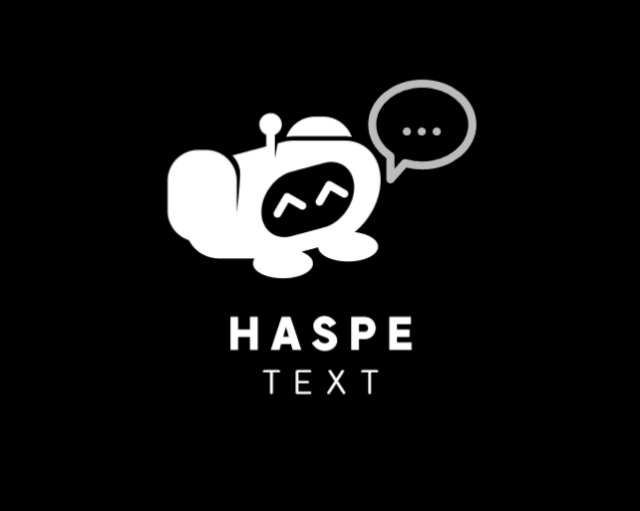

# **Installing and Importing Libraries**

In [1]:
!pip install python-telegram-bot
!pip install nest_asyncio
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00


In [2]:
import nest_asyncio
nest_asyncio.apply()

from typing import Final
import telegram
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes
import joblib
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the Saved Model and Definining Functions**

In [4]:
# Haspe Text Bot Constants
TOKEN: Final = 'Telegram Bot API Token'
BOT_USERNAME: Final = 'Telegram Bot API Username'

# Load the BERT model and tokenizer
model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

# Load the TensorFlow model
tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'

# Load the label encoder
label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
loaded_label_encoder = joblib.load(label_encoder_filename)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Hate Speech Detection Project/Project Execution/Backend Development/Hate Speech Detection Models/Mark 12/Saved Model/Hate Speech Hinglish Language/hate_speech_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [5]:
# Define hateful emoticons
hateful_emojis = [u'😠', u'😡', u'🤬', u'🥵', u'🤢', u'🤮', u'👿', u'💩', u'👎', u'👎🏻', u'👎🏼', u'👎🏽', u'👎🏾', u'👎🏿', u'🖕', u'🖕🏻', u'🖕🏼', u'🖕🏽', u'🖕🏾', u'🖕🏿', u'👙', u'🩱', u'💦', u'🍌', u'🍑', u'🥊', u'🏴‍☠️']

# Function to predict hate speech
def load_model_and_predict(text):
    # Tokenize and preprocess the input text
    encoding = loaded_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Make prediction
    with tf.device('/cpu:0'):  # Ensure predictions are made on CPU
        outputs = loaded_model.predict([input_ids, attention_mask])
        logits = outputs.logits

    # Convert logits to probabilities and get the predicted label
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = loaded_label_encoder.classes_[predicted_label_id]

    return predicted_label

# **Code for Bot 1 - Haspe Text**

In [6]:
# Command handlers
async def start_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Hello! Thanks for chatting with me! I am the Haspe Text Bot.')

async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('I am Haspe Text Bot. Please give me input in Text Format to detect if its Hate or Non-Hate 😊')

async def text_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Type the text to be classified as Hate or Non-Hate.')

async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    # Check if the message has text content
    if update.message.text is None:
        await update.message.reply_text('The given input is not in text format. Please enter Text as Input.')
        return

    text = update.message.text
    await update.message.reply_text('Processing your text. Please wait...')

    # Check if user input contains hateful emoticons
    contains_hateful_emojis = any(emoji in text for emoji in hateful_emojis)

    if contains_hateful_emojis:
        response = f'Text Entered: {text}\nPredicted Output: Hate'
        await update.message.reply_text(response)
    else:
        predicted_label = load_model_and_predict(text)
        # Change the label from "yes"/"no" to "Hate"/"Non-Hate"
        label = "Hate" if predicted_label == "yes" else "Non-Hate"
        response = f'Text Entered: {text}\nPredicted Output: {label}'
        await update.message.reply_text(response)

async def error(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print(f'Update {update} caused error {context.error}')

if __name__ == '__main__':
    app = Application.builder().token(TOKEN).build()

    app.add_handler(CommandHandler('start', start_command))
    app.add_handler(CommandHandler('help', help_command))
    app.add_handler(CommandHandler('text', text_command))

    # Handle messages
    app.add_handler(MessageHandler(filters.ALL, handle_message))

    # Handle errors
    app.add_error_handler(error)

In [ ]:
# Start polling
print('Polling...')
app.run_polling(poll_interval=3)

Polling...
